In [29]:
# Create the Kaggle directory and copy the API token

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [32]:
# Download the dataset from kaggle

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:04<00:00, 241MB/s]
100% 1.06G/1.06G [00:04<00:00, 232MB/s]


In [31]:
# Unzip the file

In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [33]:
# Import the necessary libraries

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,BatchNormalization
from keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

In [36]:
# Load EfficientNetB0 with ImageNet weights, excluding the top layer for transfer learning
# Do not include the top layer as we'll add our own
# Set layers before 'top_conv' as non-trainable to freeze them

In [5]:
efficientnetB0_convolutional_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
efficientnetB0_convolutional_base.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [38]:
# Set layers before 'top_conv' as non-trainable to freeze them
# Unfreeze the layers from the 'top_conv' layer by setting them up as trainable

In [7]:
efficientnetB0_convolutional_base.trainable = False
set_trainable_efficientnetB0 = False
for layer in efficientnetB0_convolutional_base.layers:
    if layer.name=='top_conv':
        set_trainable_efficientnetB0=True
    layer.trainable=set_trainable_efficientnetB0

for layer in efficientnetB0_convolutional_base.layers:
    print(layer.name,layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [8]:
efficientnetB0_model=Sequential()
efficientnetB0_model.add(efficientnetB0_convolutional_base)
efficientnetB0_model.add(Flatten())
efficientnetB0_model.add(Dense(256,activation='relu'))
efficientnetB0_model.add(BatchNormalization())
efficientnetB0_model.add(Dense(1,activation='sigmoid'))

In [9]:
efficientnetB0_model.build(input_shape=(None,224,224,3))

In [10]:
from keras.optimizers import Adam
efficientnetB0_model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Load training data with 80% training and 20% validation split

In [11]:
image_size = (224, 224)
batch_size = 16

train_generator = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_generator = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset='validation',
    seed=42
)

test_generator = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=image_size
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Found 5000 files belonging to 2 classes.


In [ ]:
# Applying a simple yet effective augmentation for this particular task

In [28]:
def augment(image,label):
    image=tf.image.random_flip_left_right(image)
    # image=tf.image.random_brightness(image,max_delta=0.2)
    image=tf.image.random_contrast(image,lower=0.8,upper=1.2)
    return image,label

train_generator=train_generator.map(augment)

In [39]:
# Training our model for 10 epochs with a batch size of 16

In [15]:
efficientnetB0_history = efficientnetB0_model.fit(train_generator,epochs=10,
                                                  batch_size=16,
                                                  validation_data=validation_generator)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.9787 - loss: 0.0607 - val_accuracy: 0.9905 - val_loss: 0.0303
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - accuracy: 0.9837 - loss: 0.0505 - val_accuracy: 0.9902 - val_loss: 0.0292
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.9849 - loss: 0.0441 - val_accuracy: 0.9910 - val_loss: 0.0287
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9846 - loss: 0.0436 - val_accuracy: 0.9908 - val_loss: 0.0286
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.9870 - loss: 0.0360 - val_accuracy: 0.9905 - val_loss: 0.0284
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - accuracy: 0.9847 - loss: 0.0388 - val_accuracy: 0.9902 - val_loss: 0.0270
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.9853 - loss: 0.0431 - val_accuracy: 0.9915 - val_loss: 0.0272
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - accuracy: 0.9875 -

In [40]:
# Evaluate the model on the test data

In [17]:
test_loss, test_accuracy = efficientnetB0_model.evaluate(test_generator)
print(f'efficientnetB0 test accuracy and accuracy: {test_accuracy,test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9888 - loss: 0.0352
efficientnetB0 test accuracy and accuracy: (0.9904000163078308, 0.030025295913219452)


In [41]:
# Visualize the predictions on test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


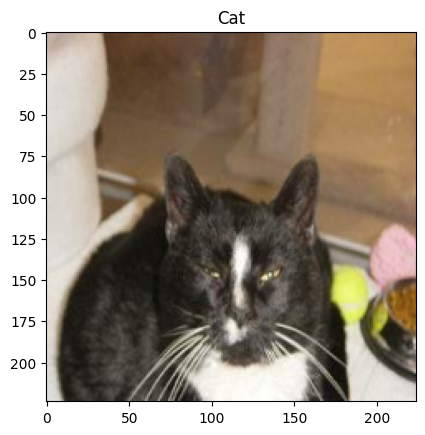

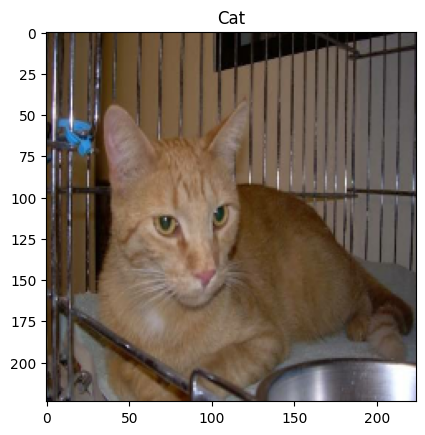

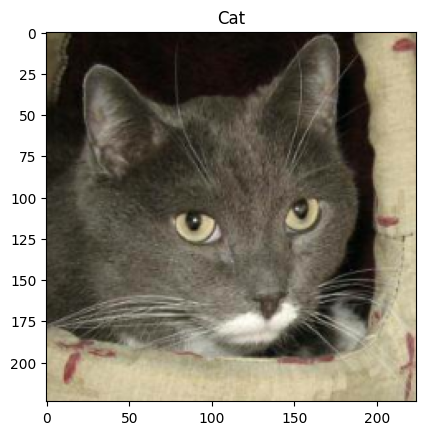

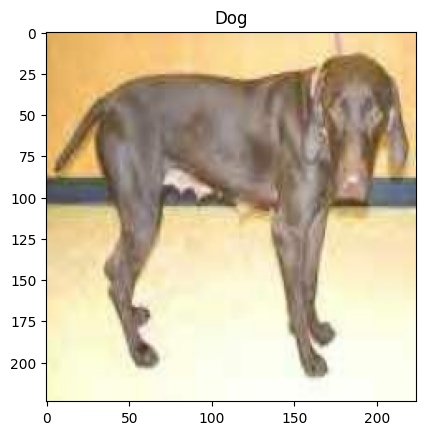

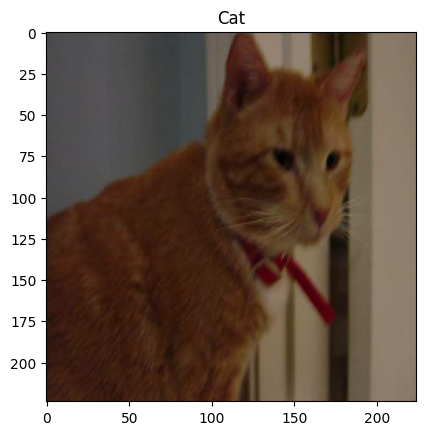

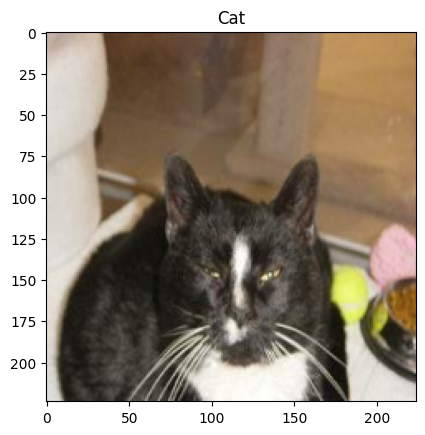

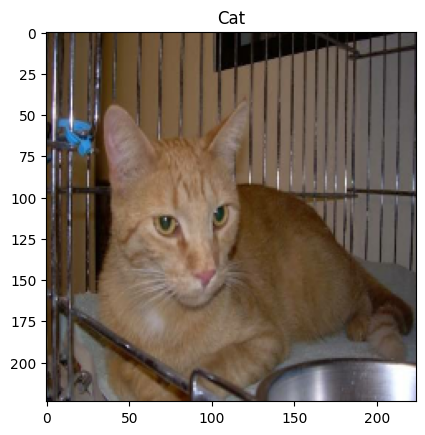

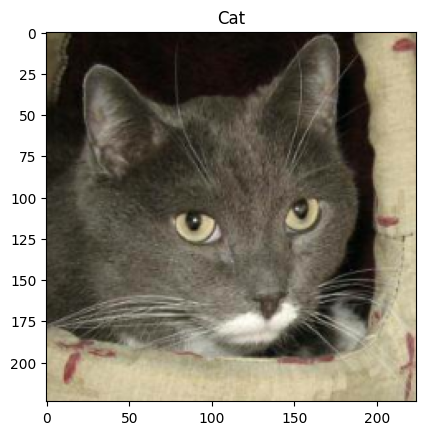

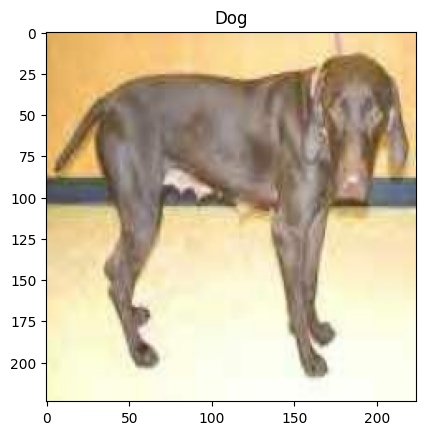

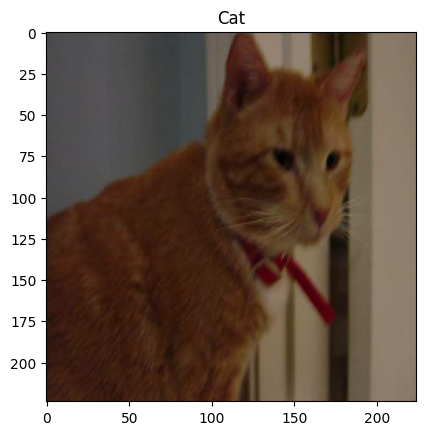

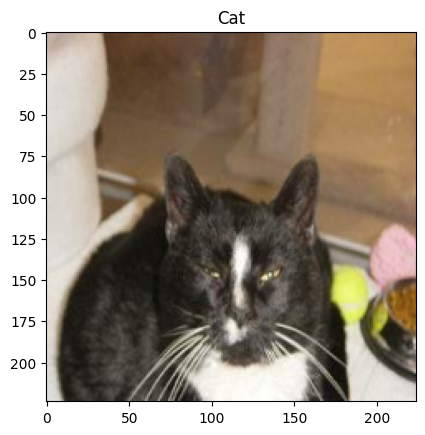

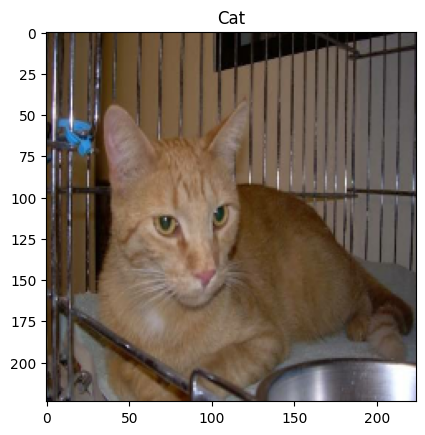

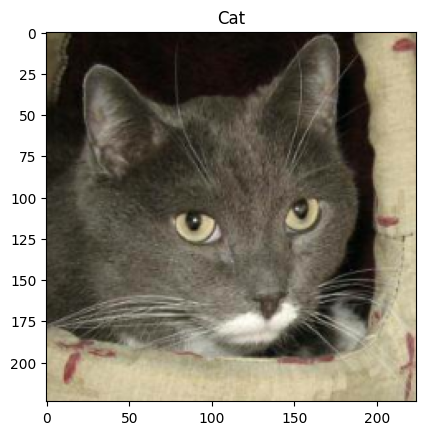

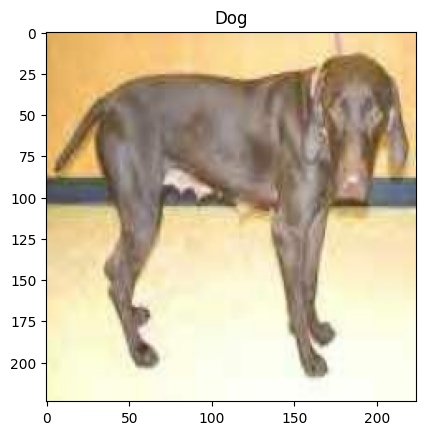

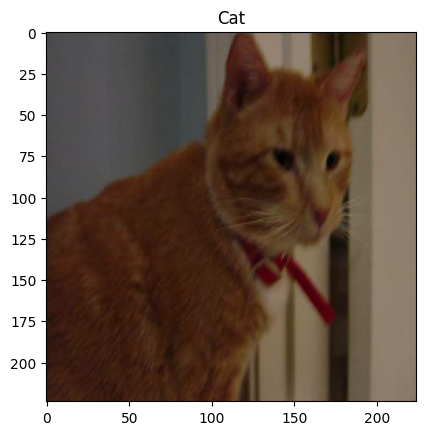

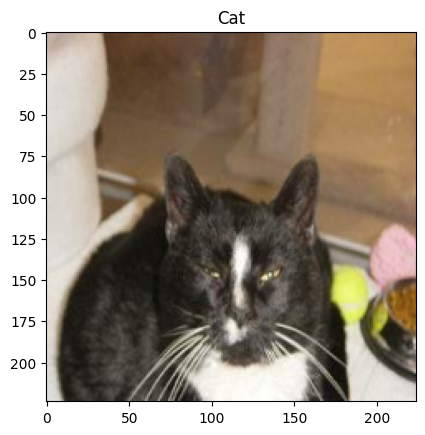

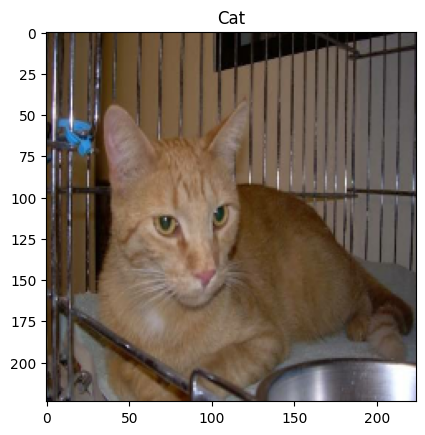

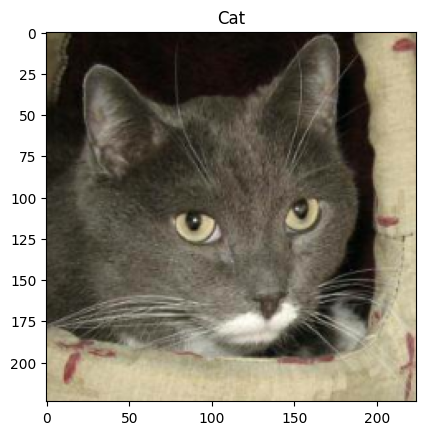

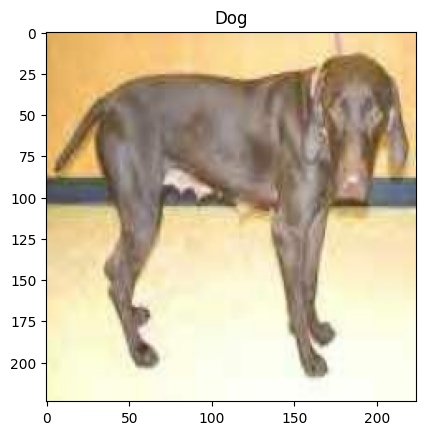

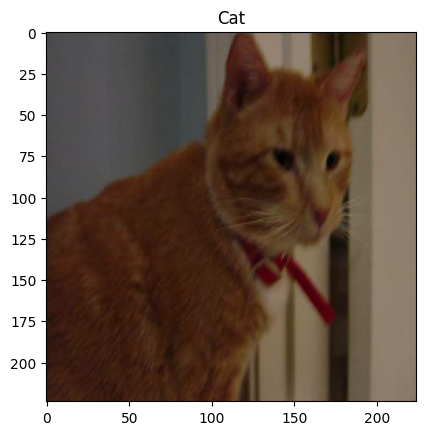

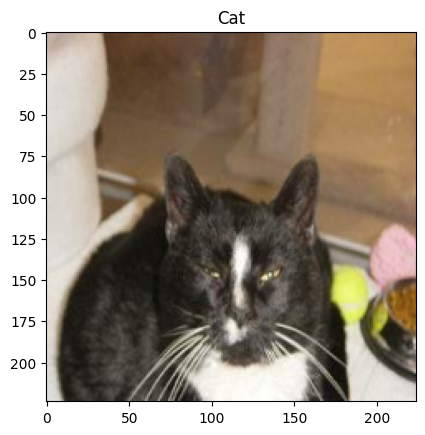

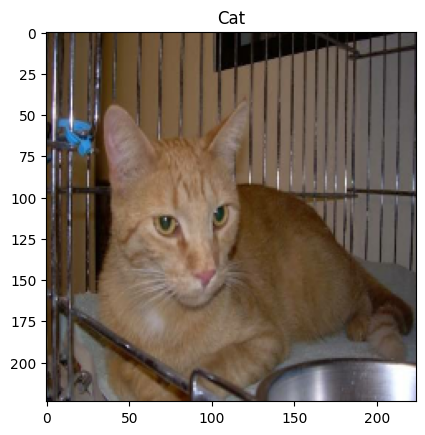

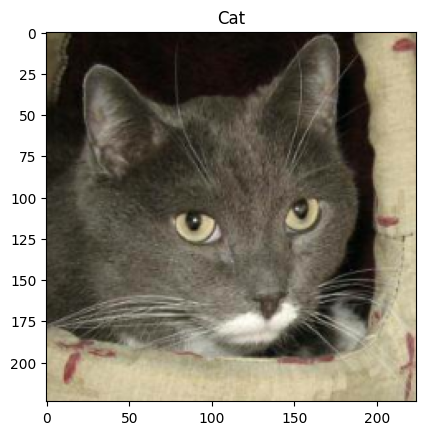

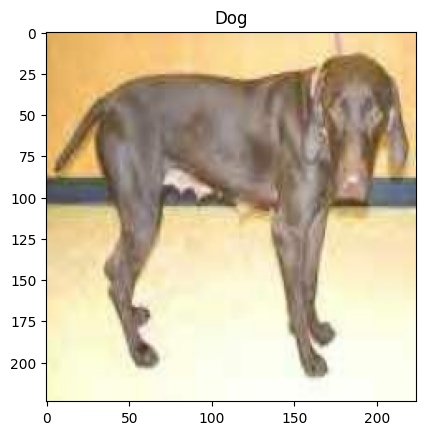

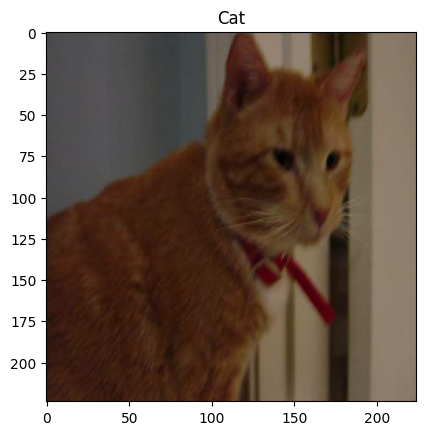

In [27]:
test_images,_=next(iter(test_generator)) # underscore is to ignore the labels (since we'er only interested in images here)
predictions=(efficientnetB0_model.predict(test_images)>0.5).astype('int32')
for i in range(5):
  for i in range(5):
    plt.imshow(test_images[i].numpy().astype('uint8'))
    title = 'Dog' if predictions[i][0] == 1 else 'Cat'
    plt.title(f'{title}')
    plt.show()